# End to End Matching Example

Please run [Record-Linkage-Example.ipynb](Record-Linkage-Example.ipynb) before this one in order to get the trained model at `../trained-models/notebooks/rl/rl-model.ckpt`.

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Loading Test Data

In [6]:
import json
from ordered_set import OrderedSet

def load_pair_set(filepath):
    with open(filepath, 'r') as f:
        test_pos_pair_set = json.load(f)
        return OrderedSet(tuple(pair) for pair in test_pos_pair_set)

train_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-train-pos-pairs.json')
valid_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-valid-pos-pairs.json')
test_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-test-pos-pairs.json')

In [7]:
import json

def load_record_dict(filepath):
    with open(filepath, 'r') as f:
        record_dict = json.load(f)
        return {int(id_): record for id_, record in record_dict.items()}

train_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-train-records.json')
valid_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-valid-records.json')
test_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-test-records.json')

## Loading Model

In [8]:
from entity_embed import LinkageEmbed

model = LinkageEmbed.load_from_checkpoint('../trained-models/notebooks/rl/rl-model.ckpt')
model = model.to(torch.device('cuda'))

## Blocking

Use `sim_threshold = 0.45` to have ~6k pairs in `train_found_pair_set` and have a fair comparison with [End-to-End-Matching-Baseline.ipynb](./End-to-End-Matching-Baseline.ipynb)

In [9]:
%%time

eval_batch_size = 64
ann_k = 100
sim_threshold = 0.45

train_found_pair_set, train_left_field_vector_dict, train_right_field_vector_dict = model.predict_pairs(
    record_dict=train_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_field_embeddings=True
)

# batch embedding:   0%|          | 0/44 [00:00<?, ?it/s]

CPU times: user 3.04 s, sys: 579 ms, total: 3.62 s
Wall time: 1.97 s


In [10]:
%%time

valid_found_pair_set, valid_left_field_vector_dict, valid_right_field_vector_dict = model.predict_pairs(
    record_dict=valid_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_field_embeddings=True
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 1.16 s, sys: 528 ms, total: 1.69 s
Wall time: 1.02 s


In [11]:
%%time

test_found_pair_set, test_left_field_vector_dict, test_right_field_vector_dict = model.predict_pairs(
    record_dict=test_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_field_embeddings=True
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 1.25 s, sys: 538 ms, total: 1.79 s
Wall time: 1.08 s


In [12]:
test_attn_scores_dict = model.interpret_attention(
    record_dict=test_record_dict,
    batch_size=eval_batch_size,
    field='title',
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

In [13]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(test_found_pair_set), len(test_record_dict))

0.9008810572687225

In [14]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(test_found_pair_set, test_pos_pair_set)

(0.2995110024449878, 0.98)

Complement the train/valid `found_pair_set` with `pos_pair_set` for training.  
Leave test untoched, to reproduce production behavior:

In [15]:
train_found_pair_set |= train_pos_pair_set
valid_found_pair_set |= valid_pos_pair_set

## Matching: Compare

Make a dataframe `df` with all records (train, valid, test) to add additional features:

In [16]:
record_dict = {**train_record_dict, **valid_record_dict, **test_record_dict}

In [17]:
import pandas as pd

df = pd.DataFrame.from_dict(record_dict, orient='index')
df = df.drop(columns='id')

In [18]:
df['all'] = df.agg('{0[title]} - {0[manufacturer]} - {0[price]}'.format, axis=1)
df['price'] = pd.to_numeric(df['price'].str.replace(' ', ''), errors='coerce')
df.head(3)

,manufacturer,price,title,__source,cluster,all
1728,,1149.00,filemaker pro 8 . 5 5 - user pack,google,1561,filemaker pro 8 . 5 5 - user pack - - 1149
255,diskeeper corporation,736.66,diskeeper 2007 pro premier 5 - lic pack,amazon,1207,diskeeper 2007 pro premier 5 - lic pack - disk...
2889,,16.00,emc securid appl mnt - ent / std 17mo per u 2k...,google,2231,emc securid appl mnt - ent / std 17mo per u 2k...


Replace all `record_dict`s (train, valid, test) to add additional features:

In [19]:
train_record_dict = df.loc[train_record_dict.keys()].to_dict(orient='index')
valid_record_dict = df.loc[valid_record_dict.keys()].to_dict(orient='index')
test_record_dict = df.loc[test_record_dict.keys()].to_dict(orient='index')

In [20]:
import textdistance as td
import math

def exact_eq(x, y):
    return float(x == y)

def token_ops(func):
    def new_func(x, y):
        return func(x.split(), y.split())    
    return new_func

def abs_diff(x, y):
    return abs(x - y)

def abs_diff_log10(x, y):
    diff = abs_diff(x, y)
    if diff > 1:
        return math.log10(diff)
    else:
        return 0.0

SIM_FUNC_DICT = {
    ("all", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("all", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("all", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("all", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("manufacturer", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("manufacturer", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("manufacturer", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("manufacturer", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("title", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("title", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("title", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("title", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("price", "abs_diff"): abs_diff,
    ("price", "abs_diff_log10"): abs_diff_log10,
}

def record_sim_func(record_pair):
    record_left, record_right = record_pair
    feature_dict = {}
    
    for (field, sim_func_name), sim_func in SIM_FUNC_DICT.items():
        x = record_left[field]
        y = record_right[field]
        if x and y:
            if sim_func_name.startswith('abs_diff') and (math.isnan(x) or math.isnan(y)):
                sim = -1.0
            else:
                sim = sim_func(x, y)
        else:
            sim = -1.0
        feature_dict[f"{field}_{sim_func_name}"] = sim
    
    return feature_dict

In [21]:
%%time

pair = next(iter(test_pos_pair_set))
id_left, id_right = pair
feature_dict = record_sim_func((test_record_dict[id_left], test_record_dict[id_right]))

# display(test_record_dict[id_left], test_record_dict[id_right])
feature_dict

CPU times: user 1.22 ms, sys: 0 ns, total: 1.22 ms
Wall time: 976 µs


{'all_jaccard': 0.5333333333333333,
 'all_overlap': 0.8,
 'all_damerau_levenshtein': 0.7068965517241379,
 'all_jaro_winkler': 0.8845771423231474,
 'manufacturer_jaccard': -1.0,
 'manufacturer_overlap': -1.0,
 'manufacturer_damerau_levenshtein': -1.0,
 'manufacturer_jaro_winkler': -1.0,
 'title_jaccard': 0.7142857142857143,
 'title_overlap': 1.0,
 'title_damerau_levenshtein': 0.8888888888888888,
 'title_jaro_winkler': 0.9652777777777778,
 'price_abs_diff': 14.709999999999994,
 'price_abs_diff_log10': 1.16761267272753}

In [22]:
from collections import defaultdict
import multiprocessing
from tqdm.auto import tqdm

def compare_pairs(record_dict, found_pair_set):
    all_feature_dict = defaultdict(list)
    chunksize = 100
    tasks = (
        (record_dict[id_left], record_dict[id_right])
        for (id_left, id_right)
        in found_pair_set
    )

    with multiprocessing.Pool() as pool:
        for feature_dict in tqdm(
            pool.imap(record_sim_func, tasks, chunksize=chunksize),
            total=len(found_pair_set)
        ):
            for feature, val in feature_dict.items():
                all_feature_dict[feature].append(val)

        pool.close()
        pool.join()
    
    return pd.DataFrame(all_feature_dict, index=pd.MultiIndex.from_tuples(found_pair_set))

In [23]:
%%time

train_feature_df = compare_pairs(train_record_dict, train_found_pair_set)
assert len(train_feature_df) == len(train_found_pair_set)
len(train_found_pair_set)

  0%|          | 0/6118 [00:00<?, ?it/s]

CPU times: user 138 ms, sys: 447 ms, total: 585 ms
Wall time: 673 ms


6118

In [24]:
%%time

valid_feature_df = compare_pairs(valid_record_dict, valid_found_pair_set)
assert len(valid_feature_df) == len(valid_found_pair_set)
len(valid_found_pair_set)

  0%|          | 0/829 [00:00<?, ?it/s]

CPU times: user 48.6 ms, sys: 408 ms, total: 457 ms
Wall time: 468 ms


829

In [25]:
%%time

test_feature_df = compare_pairs(test_record_dict, test_found_pair_set)
assert len(test_feature_df) == len(test_found_pair_set)
len(test_found_pair_set)

  0%|          | 0/818 [00:00<?, ?it/s]

CPU times: user 45.9 ms, sys: 410 ms, total: 456 ms
Wall time: 484 ms


818

## Matching: Compare - TFIDF Feature

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_vectorizer(train_record_dict, valid_record_dict, field='all'):
    tfidf_vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2,4),
        min_df=2
    )
    train_valid_record_dict = {**train_record_dict, **valid_record_dict}
    tfidf_vectorizer.fit(record[field] for record in train_valid_record_dict.values())
    return tfidf_vectorizer

tfidf_vectorizer = get_tfidf_vectorizer(train_record_dict, valid_record_dict)
tfidf_vectorizer

TfidfVectorizer(analyzer='char', min_df=2, ngram_range=(2, 4))

In [27]:
import numpy as np

def add_tfidf_feature(tfidf_vectorizer, feature_df, record_dict, found_pair_set, field='all'):
    tfidf_matrix = tfidf_vectorizer.transform(record[field] for record in record_dict.values())

    id_to_idx = {id_: idx for idx, id_ in enumerate(record_dict.keys())}
    left_idx = [id_to_idx[left_id] for left_id, __ in found_pair_set]
    right_idx = [id_to_idx[right_id] for __, right_id in found_pair_set]
    tfidf_sim = tfidf_matrix[left_idx].multiply(tfidf_matrix[right_idx]).sum(axis=1)  # cos per row

    feature_df[f'{field}_tfidf'] = tfidf_sim

In [28]:
%%time

add_tfidf_feature(tfidf_vectorizer, train_feature_df, train_record_dict, train_found_pair_set)

CPU times: user 228 ms, sys: 7.27 ms, total: 235 ms
Wall time: 235 ms


In [29]:
%%time

add_tfidf_feature(tfidf_vectorizer, valid_feature_df, valid_record_dict, valid_found_pair_set)

CPU times: user 78.9 ms, sys: 3.15 ms, total: 82.1 ms
Wall time: 81.7 ms


In [30]:
%%time

add_tfidf_feature(tfidf_vectorizer, test_feature_df, test_record_dict, test_found_pair_set)

CPU times: user 80.8 ms, sys: 0 ns, total: 80.8 ms
Wall time: 80.5 ms


## Matching: Compare - Embedding Cosine Feature 

In [31]:
import numpy as np
from sklearn.preprocessing import normalize

def add_embed_cos_features(feature_df, left_field_vector_dict, right_field_vector_dict, found_pair_set):
    fields = next(iter(left_field_vector_dict.values())).keys()
    
    for field in fields:
        left_embed = np.stack([left_field_vector_dict[left_id][field] for left_id, __ in found_pair_set])
        right_embed = np.stack([right_field_vector_dict[right_id][field] for __, right_id in found_pair_set])
        normalize(left_embed, copy=False)
        normalize(right_embed, copy=False)
        sim = np.multiply(left_embed, right_embed).sum(axis=1)  # cos per row
        feature_df[f'embed_{field}_cos'] = sim

In [32]:
%%time

add_embed_cos_features(
    train_feature_df,
    train_left_field_vector_dict,
    train_right_field_vector_dict,
    train_found_pair_set)

CPU times: user 80.7 ms, sys: 99 µs, total: 80.8 ms
Wall time: 80.3 ms


In [33]:
%%time

add_embed_cos_features(
    valid_feature_df,
    valid_left_field_vector_dict,
    valid_right_field_vector_dict,
    valid_found_pair_set)

CPU times: user 12.9 ms, sys: 477 µs, total: 13.4 ms
Wall time: 13 ms


In [34]:
%%time

add_embed_cos_features(
    test_feature_df,
    test_left_field_vector_dict,
    test_right_field_vector_dict,
    test_found_pair_set)

CPU times: user 12.7 ms, sys: 368 µs, total: 13.1 ms
Wall time: 12.8 ms


## Matching: Classify

In [35]:
train_valid_feature_df = pd.concat([train_feature_df, valid_feature_df])
train_valid_feature_df.head(3)

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,manufacturer_jaccard,manufacturer_overlap,manufacturer_damerau_levenshtein,manufacturer_jaro_winkler,title_jaccard,title_overlap,title_damerau_levenshtein,title_jaro_winkler,price_abs_diff,price_abs_diff_log10,all_tfidf,embed_title_cos,embed_title_semantic_cos,embed_manufacturer_cos,embed_price_cos
272,3735,0.388889,0.777778,0.372093,0.680656,-1.0,-1.0,-1.0,-1.0,0.454545,1.000000,0.277778,0.855556,0.05,0.000000,0.493292,0.997033,0.975395,0.0,0.786074
938,2238,0.400000,0.571429,0.214286,0.721501,-1.0,-1.0,-1.0,-1.0,0.230769,0.428571,0.351852,0.696147,3.15,0.498311,0.648477,0.845646,0.962075,0.0,0.835909
352,4234,0.615385,0.888889,0.431034,0.718774,-1.0,-1.0,-1.0,-1.0,0.400000,0.666667,0.375000,0.719444,0.00,0.000000,0.464960,0.871016,0.965327,0.0,1.000000


In [36]:
train_true_y = np.array([pair in train_pos_pair_set for pair in train_found_pair_set], dtype='i4')
valid_true_y = np.array([pair in valid_pos_pair_set for pair in valid_found_pair_set], dtype='i4')
test_true_y = np.array([pair in test_pos_pair_set for pair in test_found_pair_set], dtype='i4')

In [37]:
train_valid_true_y = np.concatenate([train_true_y, valid_true_y])

In [38]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import PredefinedSplit, GridSearchCV

cv = PredefinedSplit(
    np.concatenate([
        np.full(train_true_y.shape[0], -1 ,dtype='i4'),
        np.zeros(valid_true_y.shape[0], dtype='i4')
    ])
)
param_grid = {
    'n_estimators': [10, 100, 200],
    'max_depth': [5, 10, 25, 50, None],
    'min_samples_leaf': [1, 3, 5],
}
clf = RandomForestClassifier(oob_score=True, random_state=random_seed)
clf = GridSearchCV(clf, param_grid, scoring='f1', cv=cv, verbose=10, n_jobs=-1)
clf.fit(train_valid_feature_df, train_valid_true_y);

Fitting 1 folds for each of 45 candidates, totalling 45 fits
CPU times: user 1.18 s, sys: 636 ms, total: 1.82 s
Wall time: 9.28 s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 25, 50, None],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [10, 100, 200]},
             scoring='f1', verbose=10)

In [39]:
clf.best_params_

{'max_depth': 50, 'min_samples_leaf': 1, 'n_estimators': 100}

In [40]:
clf.best_score_

0.7222222222222221

In [41]:
clf.best_estimator_.oob_score_

0.9270188570606017

In [42]:
feature_importances = dict(zip(train_valid_feature_df.columns, clf.best_estimator_.feature_importances_))
sorted(feature_importances.items(), key=lambda kv: kv[1], reverse=True)

[('all_tfidf', 0.1487553747822736),
 ('embed_title_cos', 0.12263588484712441),
 ('title_overlap', 0.11539592187528142),
 ('embed_title_semantic_cos', 0.10274591751841643),
 ('all_jaccard', 0.06983456554665411),
 ('all_overlap', 0.06764329073862502),
 ('price_abs_diff', 0.05006557528881823),
 ('title_jaccard', 0.04780343082353675),
 ('price_abs_diff_log10', 0.04780314189059668),
 ('embed_price_cos', 0.047735623839652214),
 ('title_damerau_levenshtein', 0.042493374949839395),
 ('all_damerau_levenshtein', 0.041734644495297346),
 ('title_jaro_winkler', 0.040968385710503624),
 ('all_jaro_winkler', 0.03530263666145815),
 ('manufacturer_damerau_levenshtein', 0.004839865312991724),
 ('embed_manufacturer_cos', 0.004250588827101876),
 ('manufacturer_jaro_winkler', 0.004062206813035222),
 ('manufacturer_jaccard', 0.003509172855059325),
 ('manufacturer_overlap', 0.0024203972237344944)]

In [43]:
from sklearn.metrics import accuracy_score

cls_threshold = 0.3
train_valid_pred_y = clf.predict_proba(train_valid_feature_df)
train_valid_pred_y[train_valid_pred_y >= cls_threshold] = 1
train_valid_pred_y[train_valid_pred_y < cls_threshold] = 0
train_valid_pred_y = train_valid_pred_y[:, 1]
accuracy_score(train_valid_pred_y, train_valid_true_y)

0.9920829134878365

In [44]:
from sklearn.metrics import precision_recall_fscore_support

prob_y = clf.predict_proba(test_feature_df)
pred_y = np.copy(prob_y)
pred_y[pred_y >= cls_threshold] = 1
pred_y[pred_y < cls_threshold] = 0
pred_y = pred_y[:, 1]
precision_recall_fscore_support(test_true_y, pred_y, labels=[1])

(array([0.792]), array([0.80816327]), array([0.8]), array([245]))

In [45]:
cls_found_pair_set = OrderedSet(test_feature_df[pred_y.astype(bool)].index)

precision_and_recall(cls_found_pair_set, test_pos_pair_set)

(0.792, 0.792)

False negatives:

In [46]:
for x, y in list(test_pos_pair_set - cls_found_pair_set)[:5]:
    print(clf.predict_proba(test_feature_df.loc[[(x, y)]]))
    display(df.loc[[x, y]])

[[0.96 0.04]]


,manufacturer,price,title,__source,cluster,all
774,adobe software,273.00,adobe software acrobat pro upgrd pro - pro mac...,amazon,876,adobe software acrobat pro upgrd pro - pro mac...
1730,,145.99,adobe acrobat v8 . 0 professional for mac upgrade,google,876,adobe acrobat v8 . 0 professional for mac upgr...


[[0.71 0.29]]


,manufacturer,price,title,__source,cluster,all
598,adobe,138.45,adobe pagemaker v7 . 0 . 2 cd mac - upg ( 1753...,amazon,1,adobe pagemaker v7 . 0 . 2 cd mac - upg ( 1753...
2318,,79.99,adobe pagemaker 7 . 0 for mac version upgrade,google,1,adobe pagemaker 7 . 0 for mac version upgrade ...


[[0.94 0.06]]


,manufacturer,price,title,__source,cluster,all
97,eagle games,20.99,tournament poker 2005,amazon,1055,tournament poker 2005 - eagle games - 20 . 99
3000,eagle games,7.95,eagle games egl 150 tournament poker - no limi...,google,1055,eagle games egl 150 tournament poker - no limi...


[[0.78 0.22]]


,manufacturer,price,title,__source,cluster,all
725,omni group,29.99,omniweb 5 . 0,amazon,432,omniweb 5 . 0 - omni group - 29 . 99
1803,,23.99,omni web 5 . 0,google,432,omni web 5 . 0 - - 23 . 99


[[0.79 0.21]]


,manufacturer,price,title,__source,cluster,all
243,microsoft,118.46,money premium 2007 win32 eng na mini box us on...,amazon,261,money premium 2007 win32 eng na mini box us on...
1504,microsoft,63.99,money prem 2007 cd minibox,google,261,money prem 2007 cd minibox - microsoft - 63 . 99


In [47]:
pair = (725, 1803)
display(test_feature_df.loc[[pair]])
clf.predict_proba(test_feature_df.loc[[pair]])

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,manufacturer_jaccard,manufacturer_overlap,manufacturer_damerau_levenshtein,manufacturer_jaro_winkler,title_jaccard,title_overlap,title_damerau_levenshtein,title_jaro_winkler,price_abs_diff,price_abs_diff_log10,all_tfidf,embed_title_cos,embed_title_semantic_cos,embed_manufacturer_cos,embed_price_cos
725,1803,0.615385,0.8,0.666667,0.875499,-1.0,-1.0,-1.0,-1.0,0.5,0.75,0.928571,0.924176,6.0,0.778151,0.63204,0.690395,0.656348,0.0,0.941464


array([[0.78, 0.22]])

Hard cases attention:

In [48]:
prob_df = pd.DataFrame(prob_y[:,1], columns=['prob'], index=test_feature_df.index)
hard_prob_df = prob_df.loc[(prob_df['prob'] >= cls_threshold) & (prob_df['prob'] <= cls_threshold + 0.01)]
hard_prob_df = hard_prob_df.loc[hard_prob_df.index.intersection(test_pos_pair_set)]
hard_prob_df

,,prob
199,3080,0.31
626,1655,0.31


In [49]:
import seaborn as sns

def display_attention(id_, field):
    val = test_record_dict[id_][field]
    attn_scores = test_attn_scores_dict[id_][:len(val.split())]
    attn_df = pd.DataFrame(dict(zip(val.split(), attn_scores)), index=[id_])
    cm = sns.light_palette("red", as_cmap=True)
    display(attn_df.style.background_gradient(cmap=cm, axis=1))

def display_pair_attention(pair, field):
    left_id, right_id = pair
    display_attention(left_id, field)
    display_attention(right_id, field)

for pair in hard_prob_df.index:
    display_pair_attention(pair, 'title')

,netmanage,upg,rumba,unix,-,hp,edition,level,(,902453,007,c,)
199,0.057146,0.101112,0.119480,0.080032,0.031046,0.125364,0.069977,0.060722,0.060377,0.060934,0.040533,0.030334,0.020653


,902453,-,007,e,rumba,unix,hp,edition,upgrade,license,1,user,volume,level,(,1000,1999
3080,0.102279,0.003963,0.082441,0.010015,0.079178,0.049410,0.067177,0.035438,0.043242,0.035807,0.038163,0.036239,0.013545,0.011515,0.007392,0.005233,0.002450


,steinberg,halion,symphonic,orchestra,virtual,instrument,(,academic,version,)
626,0.141353,0.196582,0.156383,0.246550,0.053718,0.031179,0.052440,0.038171,0.053120,0.030504


,steinberg,software,halion,symphonic,orchestra,-,educational,edition
1655,0.093124,0.024840,0.162571,0.166473,0.337038,0.109533,0.057111,0.049310


<Figure size 1152x720 with 0 Axes>

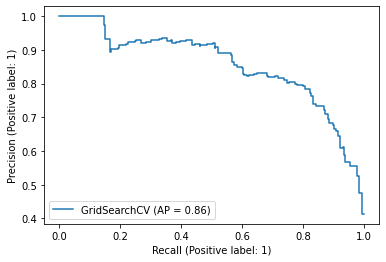

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

plt.figure(figsize=(16,10))

disp = plot_precision_recall_curve(clf, test_feature_df, test_true_y)